In [48]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from dataset_tools import MNIST


cuda = torch.cuda.is_available()
print(cuda)

ImportError: attempted relative import with no known parent package

# Data

In [32]:
flatten = lambda x: ToTensor()(x).view(-1)

# data_train = MNIST(train=True, transform=ToTensor())
# data_test = MNIST(train=False, transform=ToTensor())
data_train = MNIST(train=True, transform=flatten)
data_test = MNIST(train=False, transform=flatten)

train_loader = DataLoader(data_train, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(data_test, batch_size=64, shuffle=True, pin_memory=cuda)



In [33]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 784]) torch.Size([64])


# VAE

In [34]:
class VAE(nn.Module):
    """
    Variational Autoencoder
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # latent space
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar




In [35]:
model = VAE(input_dim=28*28, hidden_dim=256, latent_dim=2)
print(model)
if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
bceloss = nn.BCELoss(reduction='sum')

def loss_function(x, x_hat, mu, logvar):
    BCE = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD





VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (logvar): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [36]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat, mu, logvar = output
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([64, 784])
x_hat.shape: torch.Size([64, 784])


## Training

In [37]:
num_epochs = 10

train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        # loss = loss_function(x, x_hat, mu, logvar)
        loss = bceloss(x_hat, x)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    train_loss.append(np.mean(batch_loss))
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")

Epoch 1/10, loss: 10817.743767907115
Epoch 2/10, loss: 9456.770708747
Epoch 3/10, loss: 9151.58779484275
Epoch 4/10, loss: 8959.224522442197
Epoch 5/10, loss: 8837.775144922707
Epoch 6/10, loss: 8735.743128144157
Epoch 7/10, loss: 8666.30253448161
Epoch 8/10, loss: 8620.172526215185
Epoch 9/10, loss: 8582.490843945729
Epoch 10/10, loss: 8538.50480420859


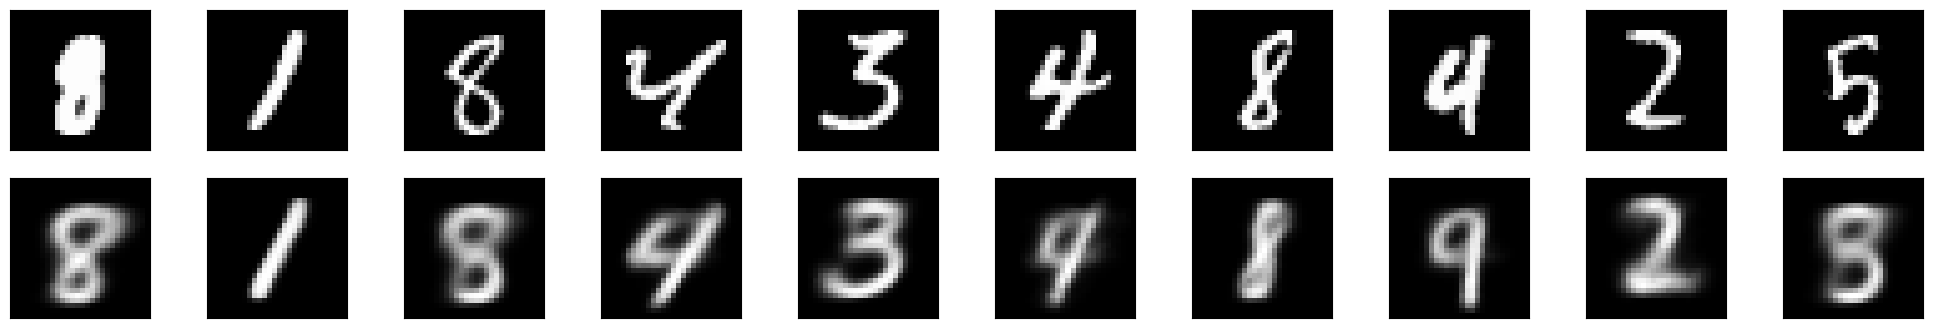

In [38]:
# test the model
model.eval()

images, labels = next(iter(test_loader))

if cuda:
    images = images.cuda()
output = model(images)
x_hat, mu, logvar = output

# plot the original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, x_hat], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.cpu().detach().view(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

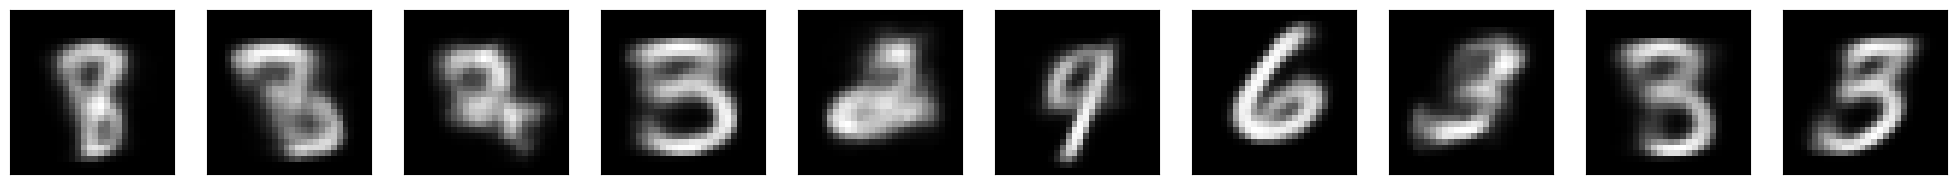

In [42]:
# generate new images using decoder
with torch.no_grad():
    z = torch.randn(10, 2)
    if cuda:
        z = z.cuda()
    new_images = model.decoder(z)

fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for img, ax in zip(new_images, axes):
    ax.imshow(img.cpu().detach().view(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
